<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Convolutional Neural Network


This is an example of classification of mnist using Convolutional Neural Network.

※If you want to perform learning, create a source file.



Import of required library.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor
import torch.nn.functional as F

Fixed seed value for random numbers.

The initial value of the weight is determined by random numbers. By fixing the seed value of the random number, the initial value of the weight is fixed to prevent different results depending on the initial value.

In [0]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Reading dataset.

Image data is stored in x_train and x_test, and labels are stored in y_train and y_test.

This part should be rewritten as appropriate depending on the data set you use.

The input image to the model should have the shape of $(N, C, H, W)$.

$N:$ number of data

$C:$ number of channnel

$H:$ height

$W:$ width

In [0]:
mnist_train = dsets.MNIST(".", download=True, train=True)
x_train = []
y_train = []
x_test = []
y_test = []

mnist_test = dsets.MNIST(".", download=True, train=False)



for i in range(len(mnist_train)):
	x_train.append(np.array(mnist_train[i][0]))
	y_train.append(mnist_train[i][1])

for i in range(len(mnist_test)):
	x_test.append(np.array(mnist_test[i][0]))
	y_test.append(mnist_test[i][1])

#Change shape to (N, C, H, W) by reshape.
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(len(mnist_train), 1, 28, 28)
x_train = x_train / 255.0

x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(len(mnist_test), 1, 28, 28)
x_test = x_test / 255.0


datasize = len(y_train)
datasize_test = len(y_test)

0it [00:00, ?it/s]

9920512it [00:01, 6729335.77it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 331335.49it/s]
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5360263.22it/s]                           
8192it [00:00, 123976.58it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Define the model structure.

The computation within the convolution layers is regarded as a filtering process of the input image as
\begin{align}
f_{p,q}^{(c)}=h(\sum^{convy-1}_{r=0}\sum^{convx-1}_{s=0}w^{(c)}_{r,s}f^{(c-1)}_{p+r, q+s}+b^{(c)}) \; ,
\end{align}

where $w^{(c)}_{r,s}$ is the weight of the neuron indexed as $(r,s)$ in the $c$-th convolution layer and $b^{(c)}$ is the bias of the $c$-th convolution layer. 

The size of the convolution filter is given as $convx \times convy$. The activation function of each neuron is denoted as $h$. 

Usually, pooling layers are added after the convolution layers. The pooling layer performs downsampling for reducing computational costs and enhancing against micro position changes. 

Fully-connected layers like multi layer perceptron is connected to the convolution layers which is used to construct the classifier. 

In this example, a model of the following structure is defined.


---

convolution layer1:(filtersize:3*3, channel:32)

convolution layer2:(filtersize:3*3, channel:32)

full connected:(128)


---



In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Definition of loss function.

The cross entropy loss is defined as the following equation.


\begin{align}
E = \sum_n^N {\boldsymbol t}_n^Tlog(S({\boldsymbol y}_n)) \; 
\end{align}

$S(\cdot)$ is an activation function of the output layer.

${\boldsymbol t_n}$ is a label and ${\boldsymbol y_n}$ is the output of the network.

In multiclass classification, the softmax function is generally used for the activation function of the output layer.

In [0]:
softmax_cross_entropy = nn.CrossEntropyLoss()

Definition of optimizer. 

In the example, the stochastic gradient descent method with momentum (SGD with momentum) is used.

$\mu$ is a learning rate and $\eta$ is a momentum parameter.

\begin{align}
{\boldsymbol w}^{(t+1)} &\leftarrow {\boldsymbol w}^{(t)} + \Delta  {\boldsymbol w}^{(t)} \\
 \Delta  {\boldsymbol w}^{(t)} &= \mu \Delta {\boldsymbol w}^{(t - 1)} - (1-\mu) \eta {\boldsymbol g}^{(t)} \\
 {\boldsymbol g}^{(t)} &= \nabla E({\boldsymbol w}^{(t)})
 \end{align}
 
In addition, regularization terms such as weight decay may be added as necessary to prevent over-learning.

In [0]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

Input data into the model for each mini-batch and perform parameter update.

(1)


In [0]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

#define batch-size and epoch.
epoch=100
batchsize=100


for epoch in range(1, epoch+1):
	print('epoch', epoch)
	perm = np.random.permutation(datasize)
	for i in range(0, datasize, batchsize):
    #Create mini-batch.
		x_batch = x_train[perm[i:i+batchsize]]
		y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
		x_batch = torch.from_numpy(x_batch).float().cuda()
		y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
		optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
		y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
		loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
		loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
		optimizer.step()



	sum_score = 0
	sum_loss = 0
  
  #Evaluate the model with train data.
	for i in range(0, datasize, batchsize):
		x_batch = x_train[i:i+batchsize]
		y_batch = y_train[i:i+batchsize]
		x_batch = torch.from_numpy(x_batch).float().cuda()
		y_batch = torch.from_numpy(y_batch).long().cuda()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
	train_loss.append(sum_loss / datasize)
	train_acc.append(sum_score / datasize)


	sum_score = 0
	sum_loss = 0

  
  #Evaluate the model with test data.
	for i in range(0, datasize_test, batchsize):
		x_batch = x_test[i:i+batchsize]
		y_batch = y_test[i:i+batchsize]
		x_batch = torch.from_numpy(x_batch).float().cuda()
		y_batch = torch.from_numpy(y_batch).long().cuda()
		y = net(x_batch)
		loss = softmax_cross_entropy(y, y_batch)
		sum_loss += float(loss.cpu().data.item()) * batchsize
		_, predict = y.max(1)
		sum_score += predict.eq(y_batch).sum().item()
	print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
	test_loss.append(sum_loss / datasize_test)
	test_acc.append(sum_score / datasize_test)


epoch 1
train  mean loss=0.13366963668571163, accuracy=0.9594666666666667
test  mean loss=0.12447499281726777, accuracy=0.9623
epoch 2
train  mean loss=0.09086479969322682, accuracy=0.9726
test  mean loss=0.0821443558507599, accuracy=0.9739
epoch 3
train  mean loss=0.0725797309121117, accuracy=0.9788166666666667
test  mean loss=0.06389289299491793, accuracy=0.9805
epoch 4


KeyboardInterrupt: ignored

Draw loss as a graph.

In [0]:
plt.figure(figsize=(6,6))

plt.ylim(0,1.0)
plt.plot(range(epoch), train_loss)
plt.plot(range(epoch), test_loss, c='#00ff00')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.show()

Draw the accuracy.

In [0]:
plt.plot(range(epoch), train_acc)
plt.plot(range(epoch), test_acc, c='#00ff00')
plt.ylim(0,1.0)
plt.legend(['train acc', 'test acc'])
plt.title('accuracy')
plt.show()

The result is as follows.

※lr (learning rate) = 0.01, weightdecay parameter = 0.005

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [0]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
weight_num = 10




#define batch-size and epoch.
epoch=100
batchsize=100

train_weight = np.zeros((epoch, weight_num))
rum_num = np.array([0,0,0,50,50,50,100,100,100,127])
perm_num = np.array([0, 500, 1500, 0, 500, 1500, 0, 500, 1500, 0])

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  
  weight = net.fc1.weight.cpu().detach().numpy()
  for i in range(weight_num):
    weight0 = weight[rum_num[i]][perm_num[i]]
    train_weight[epoch-1][i] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
train  mean loss=0.14651573360587158, accuracy=0.9558666666666666
test  mean loss=0.1356994131859392, accuracy=0.9594
epoch 2
train  mean loss=0.08203396528027952, accuracy=0.9761
test  mean loss=0.07677986116614192, accuracy=0.9769
epoch 3
train  mean loss=0.06919995703734458, accuracy=0.9805666666666667
test  mean loss=0.06551994951674715, accuracy=0.9813
epoch 4
train  mean loss=0.06958522310790917, accuracy=0.9799333333333333
test  mean loss=0.06170056935865432, accuracy=0.9823
epoch 5
train  mean loss=0.0622772002290003, accuracy=0.9826
test  mean loss=0.05924276405829005, accuracy=0.9811
epoch 6
train  mean loss=0.06129298123996705, accuracy=0.9839666666666667
test  mean loss=0.06034741123323329, accuracy=0.981
epoch 7
train  mean loss=0.0609460744393679, accuracy=0.9827833333333333
test  mean loss=0.057828608544077724, accuracy=0.9825
epoch 8
train  mean loss=0.064394698261749, accuracy=0.9812
test  mean loss=0.06342581906006671, accuracy=0.981
epoch 9
train  mean loss=0

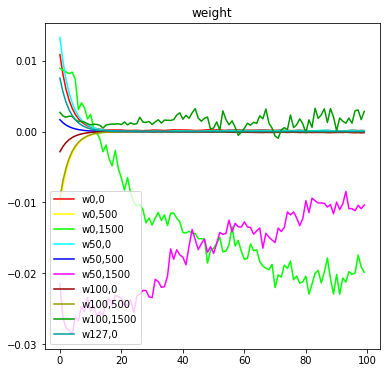

In [0]:
plt.figure(figsize=(6,6))
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

train_weight = train_weight.transpose(1,0)
for i in range(weight_num):
  plt.plot(range(epoch), train_weight[i], c=c[i])
plt.legend(['w0,0', 'w0,500', 'w0,1500', 'w50,0', 'w50,500', 'w50,1500', 'w100,0', 'w100,500', 'w100,1500', 'w127,0'])
plt.title('weight')
plt.show()

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [0]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]




#define batch-size and epoch.
epoch=100
batchsize=100


inputc_num = np.array([0,0,0])
outputc_num = np.array([0,16,31])

weight_num = int(len(inputc_num))
k_size = int(net.conv1.weight.cpu().detach().numpy().shape[2])

train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  
  weight = net.conv1.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


epoch 1
train  mean loss=0.14658301988306144, accuracy=0.95515
test  mean loss=0.13940209291875363, accuracy=0.9584
epoch 2
train  mean loss=0.09307217036684354, accuracy=0.9724333333333334
test  mean loss=0.08687562254839577, accuracy=0.9726
epoch 3
train  mean loss=0.09842329813322673, accuracy=0.96905
test  mean loss=0.09330595828359947, accuracy=0.9702
epoch 4
train  mean loss=0.06597909434698522, accuracy=0.9815
test  mean loss=0.06353034775005653, accuracy=0.9793
epoch 5
train  mean loss=0.0661866259885331, accuracy=0.9805666666666667
test  mean loss=0.0642500641325023, accuracy=0.9787
epoch 6
train  mean loss=0.06578775910194963, accuracy=0.9802666666666666
test  mean loss=0.06410416142782197, accuracy=0.9793
epoch 7
train  mean loss=0.06548171238585686, accuracy=0.9806333333333334
test  mean loss=0.06418379296083003, accuracy=0.98
epoch 8
train  mean loss=0.06197195754308874, accuracy=0.9825
test  mean loss=0.059687457403633744, accuracy=0.9824
epoch 9
train  mean loss=0.068508

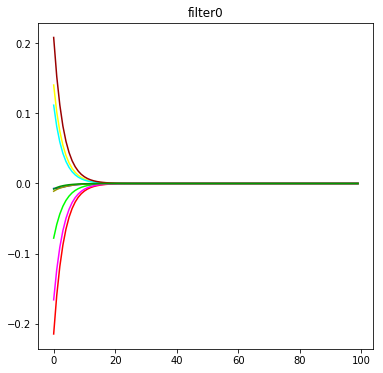

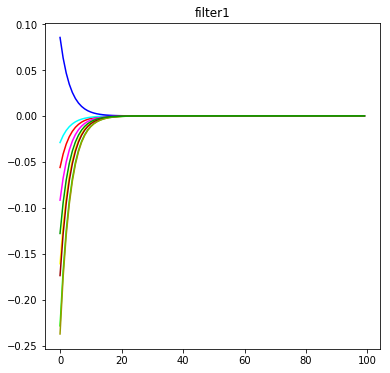

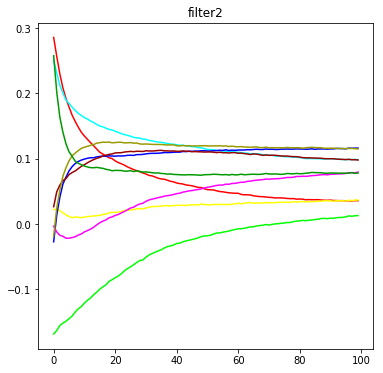

In [0]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [0]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]



#define batch-size and epoch.
epoch=100
batchsize=100


inputc_num = np.array([0,16,28])
outputc_num = np.array([0,16,25])

weight_num = int(len(inputc_num))
k_size = int(net.conv2.weight.cpu().detach().numpy().shape[2])

train_weight = np.zeros((weight_num, epoch, k_size*k_size))

for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()
  
  weight = net.conv2.weight.cpu().detach().numpy()
  
  for i in range(weight_num):
    weight0 = weight[outputc_num[i]][inputc_num[i]]
    weight0 = weight0.flatten()
    train_weight[i][epoch-1] = weight0


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)


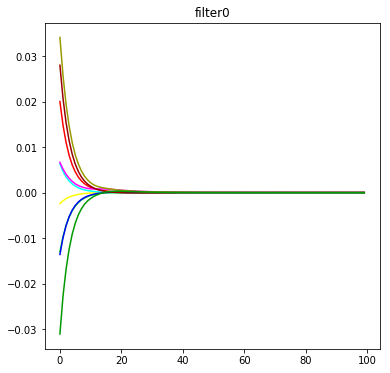

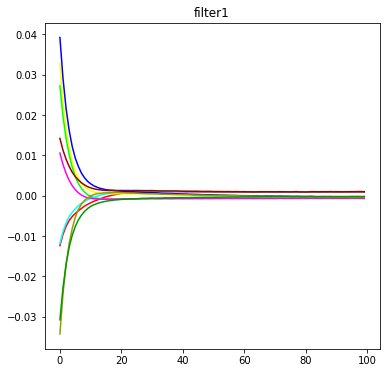

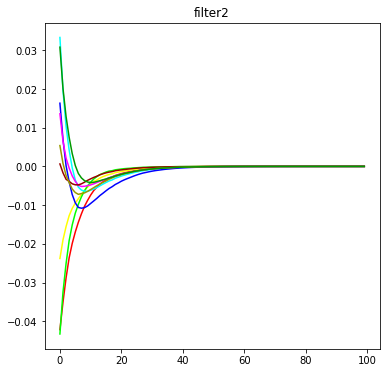

In [0]:
#A list for specifying the color of the graph. Changes are required according to the number of weights to be displayed.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']

for i in range(weight_num):
  plt.figure(figsize=(6,6))
  p = train_weight[i]
  p = p.transpose(1,0)
  for j in range(k_size*k_size):
    plt.plot(range(epoch), p[j], c=c[j])
  plt.title('filter%d'%i)
  plt.show()

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32,32,3, padding=1)
        self.fc1 = nn.Linear(32*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Network()
net.cuda()


optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

In [0]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]



#define batch-size and epoch.
epoch=100
batchsize=100


for epoch in range(1, epoch+1):
  print('epoch', epoch)
  perm = np.random.permutation(datasize)
  for i in range(0, datasize, batchsize):
    #Create mini-batch.
    x_batch = x_train[perm[i:i+batchsize]]
    y_batch = y_train[perm[i:i+batchsize]]
    
    #Convert a numpy array to a tensor to do gradient calculations.
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    
    #Initialize the stored gradient.
    optimizer.zero_grad()
    
    #Get the model output for the input mini-batch.
    y = net(x_batch)
    
    #Calculate loss from the output of the model. At this time, the activation function of the output layer is also reflected in the calculation.
    loss = softmax_cross_entropy(y, y_batch)  
    
    #From loss, calculate the gradient of each parameter.
    loss.backward()               
    
    #Each parameter is updated from the calculated gradient.
    optimizer.step()


  sum_score = 0
  sum_loss = 0
  
  #Evaluate the model with train data.
  for i in range(0, datasize, batchsize):
    x_batch = x_train[i:i+batchsize]
    y_batch = y_train[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("train  mean loss={}, accuracy={}".format(sum_loss / datasize, sum_score / datasize))
  train_loss.append(sum_loss / datasize)
  train_acc.append(sum_score / datasize)


  sum_score = 0
  sum_loss = 0

  
  #Evaluate the model with test data.
  for i in range(0, datasize_test, batchsize):
    x_batch = x_test[i:i+batchsize]
    y_batch = y_test[i:i+batchsize]
    x_batch = torch.from_numpy(x_batch).float().cuda()
    y_batch = torch.from_numpy(y_batch).long().cuda()
    y = net(x_batch)
    loss = softmax_cross_entropy(y, y_batch)
    sum_loss += float(loss.cpu().data.item()) * batchsize
    _, predict = y.max(1)
    sum_score += predict.eq(y_batch).sum().item()
  print("test  mean loss={}, accuracy={}".format(sum_loss / datasize_test, sum_score / datasize_test))
  test_loss.append(sum_loss / datasize_test)
  test_acc.append(sum_score / datasize_test)
  
  
  

result = np.zeros((datasize, 32, 28, 28))

for i in range(0, datasize, batchsize):
  x_batch = x_train[i:i+batchsize]
  x_batch = torch.from_numpy(x_batch).float().cuda()
  fmap = net.conv1(x_batch)
  result[i:i+batchsize] = fmap
  
  

for i in range(10):
	pic = result[i]
	#pic=pic.transpose(1,2,0)
	#print(pic.shape)
	pic= pic.reshape((28,28))
	io.imsave("./imgtrain%d.png"%i, pic)


for i in range(10):
	pic = result_test[i]
	#pic=pic.transpose(1,2,0)
	#print(pic.shape)
	pic= pic.reshape((28,28))
	io.imsave("./imgtest%d.png"%i, pic)


epoch 1
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
torch.Size([100, 32, 14, 14])
to

KeyboardInterrupt: ignored